In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outdir='/work/jet/data/interim/'

north_str = '600S'
dset = '_southof%s_swmt_onvoffshelf_'%north_str
lstr = 'sigma2'
dl = '002'

mods = ['OM4p5_CORE','OM4p25_CORE','OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3','ACCESS_OM2_01',
        'CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1', 'CM4_piControl_c192_OM4p125_v7']
# OM4p25_JRA55do1.4_0netfw_cycle1, CM4_piControl_c192_OM4p125_v5, 'CM4_piControl_c192_OM4p125_v6_alt2','CM4_piControl_c192_OM4p125_v6_alt3'
ddict = {mod:{} for mod in mods}

for mod in ddict:
    files = glob.glob(outdir+mod+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
    if len(files)>1:
        print('WARNING: More than one file for '+mod)
        print('Loading '+files[0])
    elif len(files)==0:
        print('ERROR: No file available for '+mod)
        ddict[mod]['dVdt' if var =='Storage change' else var] = []
        continue
        
    ddict[mod] = xr.open_dataset(files[0])

## Open ocean versus shelf

In [3]:
tcm4 = ['0081', '0090']
tom4 = ['1958', '1967']
tom2 = ['1938', '1947']

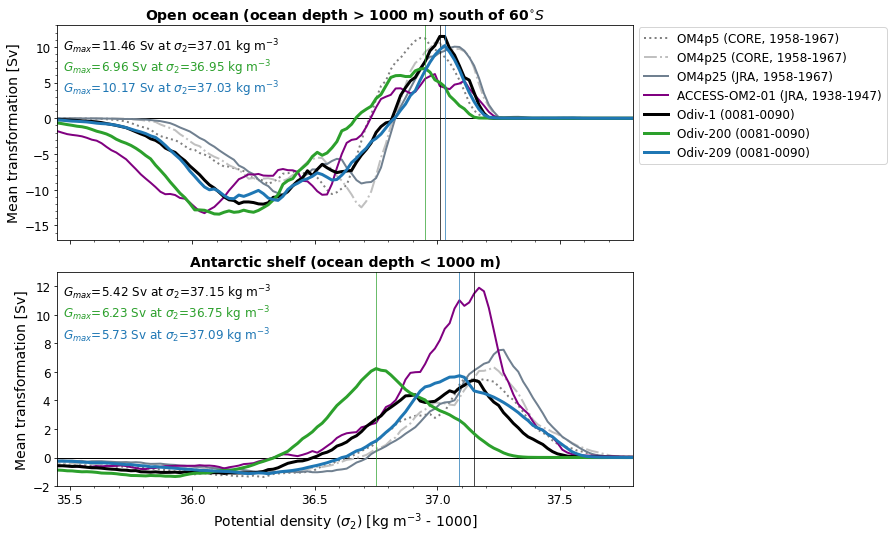

In [4]:
cstr = ['grey','silver','slategrey','purple','k','tab:green','tab:blue']#,'tab:orange','tab:red']
lsty = [':','-.','-','-','-','-','-','-']
mstr = ['OM4p5 (CORE, %s-%s)'%(tom4[0],tom4[1]),'OM4p25 (CORE, %s-%s)'%(tom4[0],tom4[1]),
        'OM4p25 (JRA, %s-%s)'%(tom4[0],tom4[1]),'ACCESS-OM2-01 (JRA, %s-%s)'%(tom2[0],tom2[1]),
        'Odiv-1 (%s-%s)'%(tcm4[0],tcm4[1]),'Odiv-200 (%s-%s)'%(tcm4[0],tcm4[1]),'Odiv-209 (%s-%s)'%(tcm4[0],tcm4[1])]
        #'Odiv-206 (%s-%s)'%(tcm4[0],tcm4[1]),'Odiv-207 (%s-%s)'%(tcm4[0],tcm4[1])]

#fig, axs = plt.subplots(2, 1, figsize=(12,8))
fig, axs = plt.subplots(2, 1, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
for i, reg in enumerate(['offshr','onshlf']):
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    
    for j, mod in enumerate(ddict):
        yr_st = tcm4[0] if mod[:3]=='CM4' else tom4[0] if mod[:3]=='OM4' else tom2[0]
        yr_ed = tcm4[1] if mod[:3]=='CM4' else tom4[1] if mod[:3]=='OM4' else tom2[1]
        #print('%s (%s-%s)'%(mod,yr_st,yr_ed))
        
        if mod[:3]=='CM4':
            G = ddict[mod][reg].sel(time=slice(yr_st,yr_ed))*1e-6
            #axs[i].fill_between(G.coords[lstr], G.mean('time')-G.groupby('time.year').mean('time').std('year'), 
            #                    G.mean('time')+G.groupby('time.year').mean('time').std('year'), alpha=0.1, color = cstr[j])
        
        G = ddict[mod][reg].sel(time=slice(yr_st,yr_ed)).mean('time')*1e-6
        axs[i].plot(G.coords[lstr], G, c = cstr[j], ls=lsty[j], lw=3 if mod[:3]=='CM4' else 2, label=mstr[j])
        
        #if mod=='CM4_piControl_c192_OM4p125_v6_alt1':
        #    G = G.sel(sigma2=slice(36.815,None)) if reg=='onshlf' else G.sel(sigma2=slice(36.98,None))
        sig_max = np.round(G[G.argmax()][lstr].values,2)
        G_max = np.round(G[G.argmax()].values,2)
        
        if mod[:3]=='CM4':
            axs[i].axvline(x=sig_max, ls='-', lw=1, alpha=0.7, c = cstr[j],label=None)
            axs[i].text(0.01, 1.35-j/10, 
                        r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max), 
                        ha='left', va='top', fontsize=12, c = cstr[j], transform=axs[i].transAxes)
            
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_xlim([35.45,37.8])
    axs[i].set_xticks(np.arange(35.5,37.8,0.1), minor=True)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14)
    #axs[i].plot(ddict['CM4_piControl_c192_OM4p125_v6_alt1'][reg].coords[lstr], 
    #            ddict['CM4_piControl_c192_OM4p125_v6_alt1'][reg].sel(time=slice('0071','0080')).mean('time')*1e-6, 
    #            c = 'g', ls='-', lw=3 , label='Odiv-200 (0071-0080)',alpha=0.5)
    if reg != 'onshlf':
        axs[i].set_xticklabels([])
        axs[i].set_ylim([-17,12])
        axs[i].set_yticks(np.arange(-16,14,1), minor=True)
    else:
        axs[i].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14)
        axs[i].set_ylim([-2,13])
        axs[i].set_yticks(np.arange(-2,14,2))
    
axs[0].set_title('Open ocean (ocean depth > 1000 m) south of 60$^{\circ}S$', fontsize=14, fontweight='bold')
axs[1].set_title('Antarctic shelf (ocean depth < 1000 m)', fontsize=14, fontweight='bold')

leg1 = axs[0].legend(frameon=True, fancybox=True, bbox_to_anchor=(1.45, 1.02), #bbox_to_anchor=(1.45, 0.27),
                     loc='upper right', ncol=1, fontsize=12)
#leg1 = axs[0].legend(frameon=True, fancybox=True, bbox_to_anchor=(0, 1.12), loc='upper left', ncol=3, fontsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Hovmoeller diagrams

In [5]:
import copy
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import hovmoeller

In [6]:
# define the colormap
#cmap = plt.cm.RdBu_r
cmap = copy.copy(plt.cm.RdBu_r)

# extract all colors from cmap
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the center colors to be white
for x in range(round(cmap.N/2-cmap.N/40),round(cmap.N/2+cmap.N/40)):
    cmaplist[x] = (0.97,0.97,0.97,1.0)
    
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cmap.set_over('maroon')
cmap.set_under('midnightblue')

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

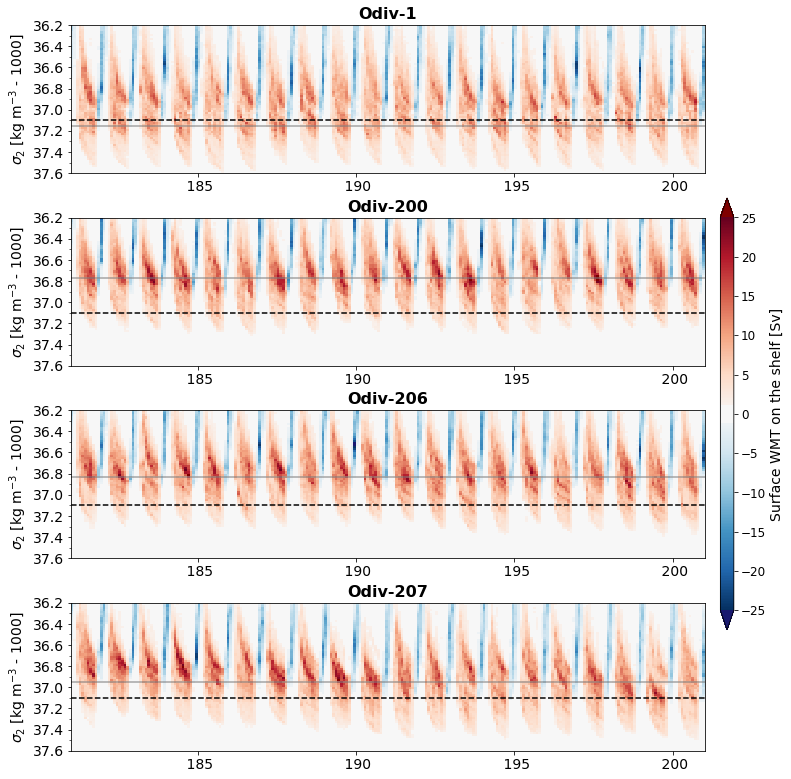

In [25]:
tcm4 = ['0181', '0200']
titlstr = ['Odiv-1','Odiv-200','Odiv-206','Odiv-207']
var = 'onshlf'
fig, axarr = plt.subplots(ncols=1, nrows=4, sharey=False, sharex=False, figsize=[11, 12])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.11, top=0.95, wspace=0.05, hspace=0.3)
for i, (ax, mod) in enumerate(zip(axarr.flat,['CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl_c192_OM4p125_v6_alt2',
                                              'CM4_piControl_c192_OM4p125_v6_alt3'])):
    yr_st = tcm4[0] if mod[:3]=='CM4' else tom4[0]
    yr_ed = tcm4[1] if mod[:3]=='CM4' else tom4[1]
    
    G = ddict[mod][var].sel(time=slice(yr_st,yr_ed))*1e-6
    
    G_mean = G.sel(time=slice('0191',yr_ed)).mean('time')
    sig_max = np.round(G_mean[G_mean.argmax()][lstr].values,2)
    #print('%.2f kg m-3'%sig_max)
    p = G.T.plot(ax=ax, yincrease=False, vmin=-25, vmax=25, cmap=cmap, add_colorbar=False, add_labels=False)
    ax.set_ylim([37.6,36.2])
    ax.set_yticks(np.arange(37.6,36.2,-0.1), minor=True)
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=37.10, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
    ax.axhline(y=sig_max, xmin=0, xmax=1, linewidth=1.5, color = 'grey',ls='-', alpha=0.7)
    ax.set_title(titlstr[i], fontsize=16,fontweight='bold')
    ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)

cax = fig.add_axes([0.92, 0.25, 0.017, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='vertical', extend='both', shrink=0.7, pad=0.02)
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

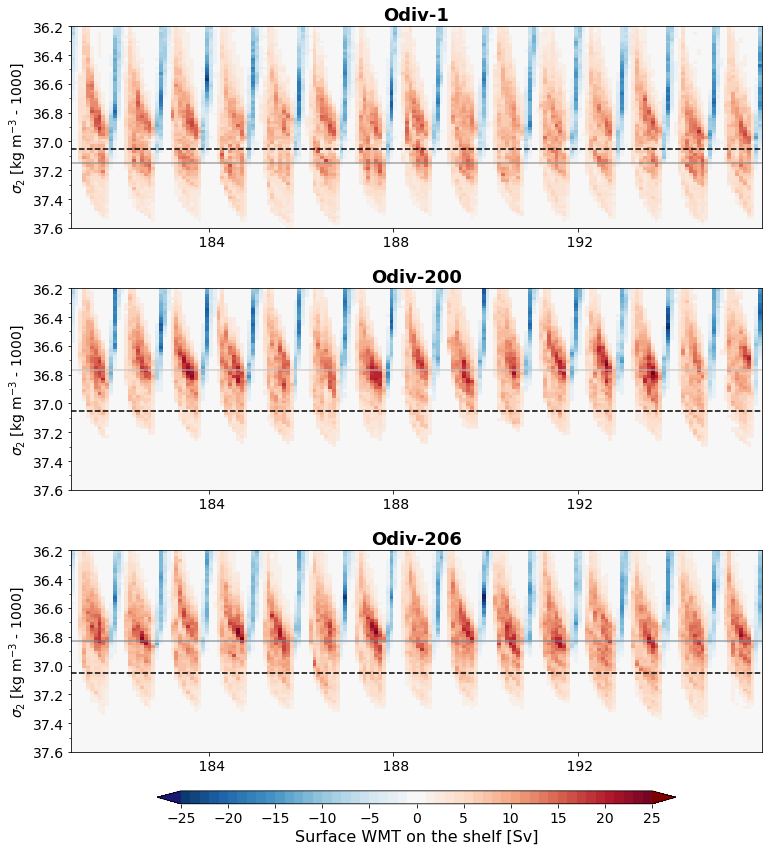

In [42]:
tcm4 = ['0181', '0195']
titlstr = ['Odiv-1','Odiv-200','Odiv-206']
var = 'onshlf'
fig, axarr = plt.subplots(ncols=1, nrows=3, sharey=False, sharex=False, figsize=[12, 12])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.11, top=0.95, wspace=0.05, hspace=0.3)
for i, (ax, mod) in enumerate(zip(axarr.flat,['CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl_c192_OM4p125_v6_alt2'])):
    yr_st = tcm4[0] if mod[:3]=='CM4' else tom4[0]
    yr_ed = tcm4[1] if mod[:3]=='CM4' else tom4[1]
    
    G = ddict[mod][var].sel(time=slice(yr_st,yr_ed))*1e-6
    
    G_mean = G.sel(time=slice('0186',yr_ed)).mean('time')
    sig_max = np.round(G_mean[G_mean.argmax()][lstr].values,2)
    #print('%.2f kg m-3'%sig_max)
    p = G.T.plot(ax=ax, yincrease=False, vmin=-25, vmax=25, cmap=cmap, levels=51,add_colorbar=False, add_labels=False)
    ax.set_ylim([37.6,36.2])
    ax.set_yticks(np.arange(37.6,36.2,-0.1), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(y=37.05, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
    ax.axhline(y=sig_max, xmin=0, xmax=1, linewidth=1.5, color = cstr[i],ls='-', alpha=0.7)
    ax.set_title(titlstr[i], fontsize=18,fontweight='bold')
    ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)

cax = fig.add_axes([0.2, 0.05, 0.60, 0.015])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='horizontal', extend='both', shrink=0.7, pad=0.02)
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

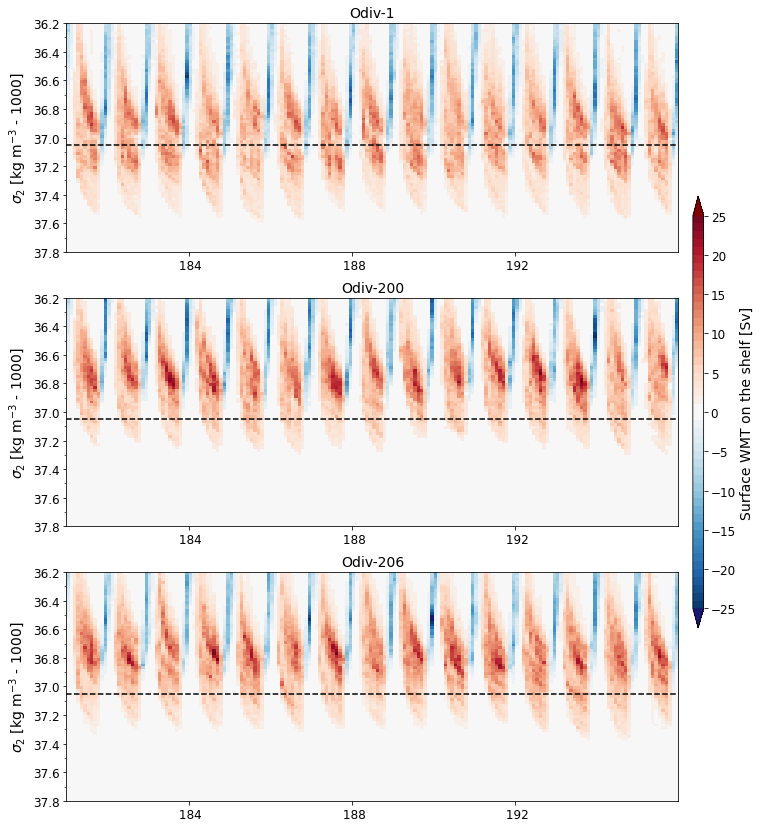

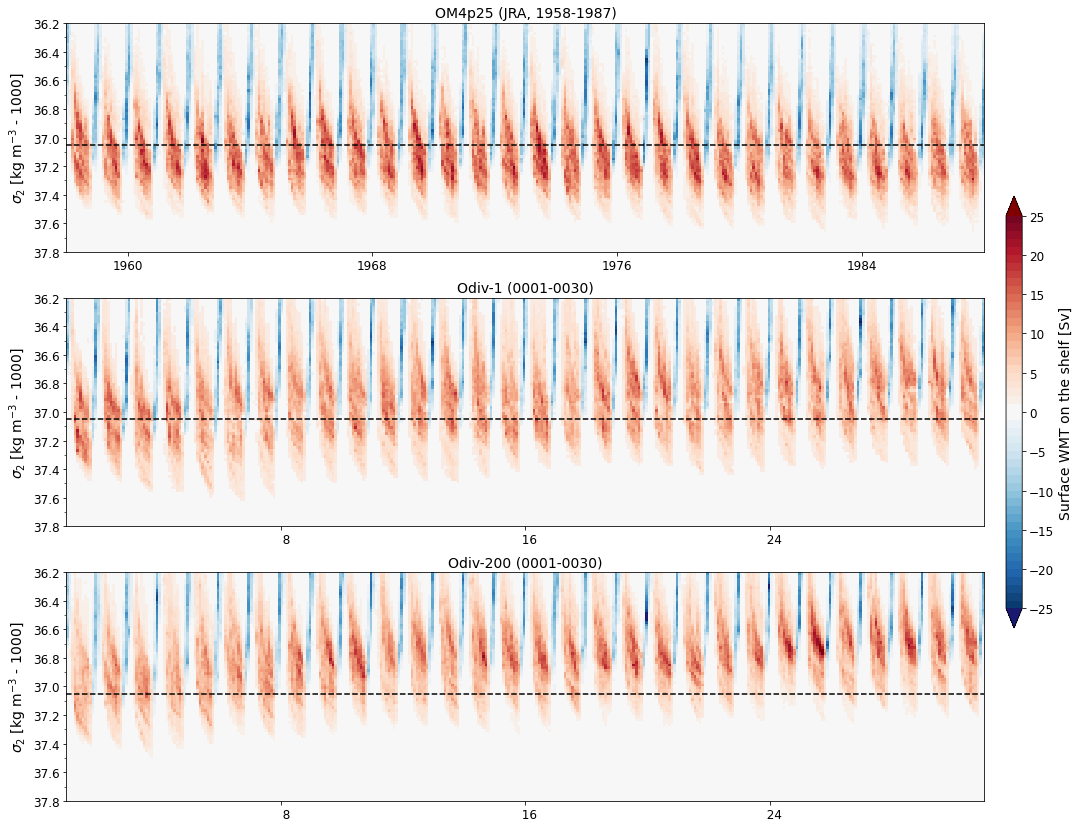

In [6]:
tcm4 = ['0001', '0030']
tom4 = ['1958', '1987']
titlstr = ['OM4p25 (JRA, %s-%s)'%(tom4[0],tom4[1]),'Odiv-1 (%s-%s)'%(tcm4[0],tcm4[1]),'Odiv-200 (%s-%s)'%(tcm4[0],tcm4[1])]
var = 'onshlf'
fig, axarr = plt.subplots(ncols=1, nrows=3, sharey=False, sharex=False, figsize=[15, 12])
fig.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.05, hspace=0.2)
for i, (ax, mod) in enumerate(zip(axarr.flat,['OM4p25_JRA55do1.4_0netfw_cycle1',#'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3',
                                              'CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1'])):
    yr_st = tcm4[0] if mod[:3]=='CM4' else tom4[0]
    yr_ed = tcm4[1] if mod[:3]=='CM4' else tom4[1]
    
    
    G = ddict[mod][var].sel(time=slice(yr_st,yr_ed))*1e-6
    p = G.T.plot(ax=ax, yincrease=False, vmin=-25, vmax=25, cmap=cmap, levels=51,add_colorbar=False, add_labels=False)
    ax.set_ylim([37.8,36.2])
    ax.set_yticks(np.arange(36.2,37.9,0.1), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axhline(y=37.05, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
    ax.set_title(titlstr[i], fontsize=14)
    ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)

cax = fig.add_axes([0.92, 0.25, 0.015, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='vertical', extend='both', shrink=0.7, pad=0.02)
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

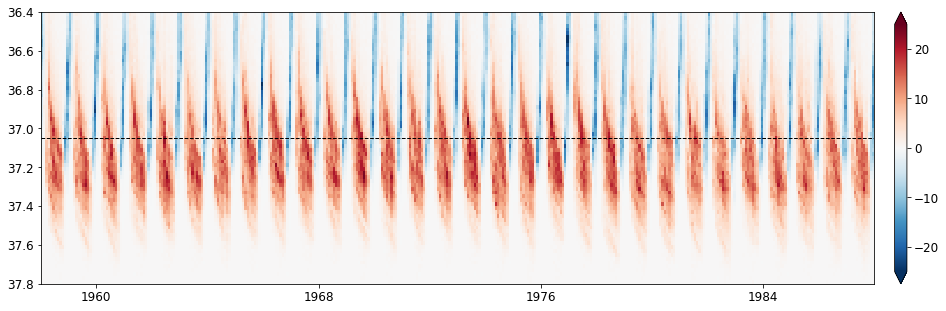

In [13]:
fig = hovmoeller(.isel(time=slice(None,360))*1e-6, fsize=[18, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.05],vrange=[-25,25],ylimrange=[37.8,36.4])

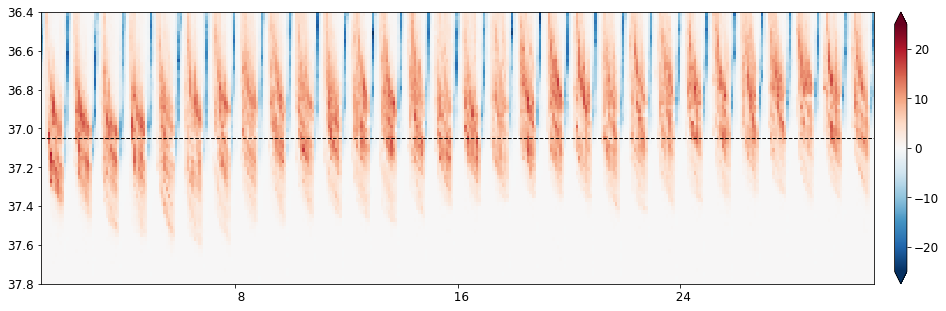

In [9]:
fig = hovmoeller(ddict['CM4_piControl'].onshlf.sel(time=slice(None,'0030'))*1e-6, fsize=[18, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.05],vrange=[-25,25],ylimrange=[37.8,36.4])

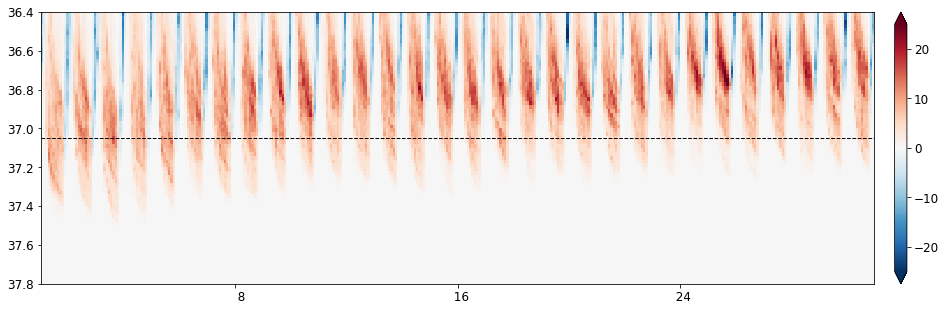

In [10]:
fig = hovmoeller(ddict['CM4_piControl_c192_OM4p125_v6_alt1'].onshlf.sel(time=slice(None,'0030'))*1e-6, fsize=[18, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.05],vrange=[-25,25],ylimrange=[37.8,36.4])

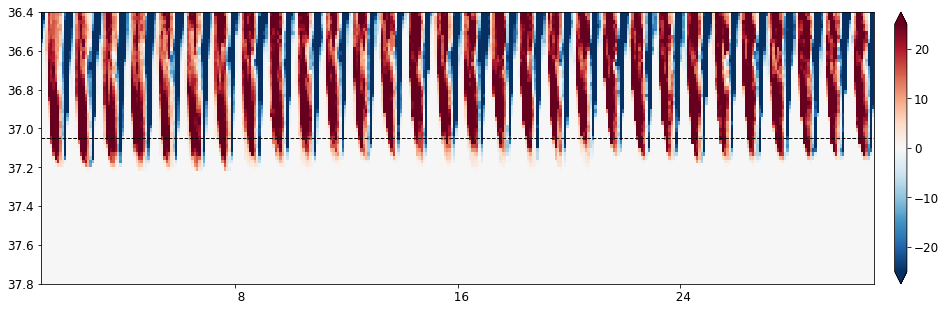

In [12]:
fig = hovmoeller(ddict['CM4_piControl'].offshr.sel(time=slice(None,'0030'))*1e-6, fsize=[18, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.05],vrange=[-25,25],ylimrange=[37.8,36.4])

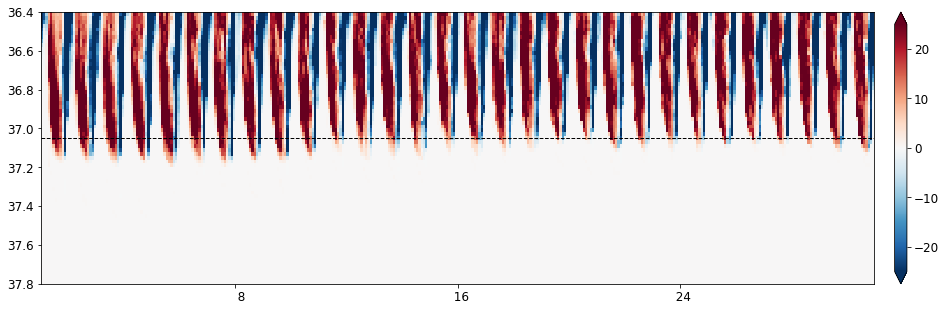

In [11]:
fig = hovmoeller(ddict['CM4_piControl_c192_OM4p125_v6_alt1'].offshr.sel(time=slice(None,'0030'))*1e-6, fsize=[18, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.05],vrange=[-25,25],ylimrange=[37.8,36.4])

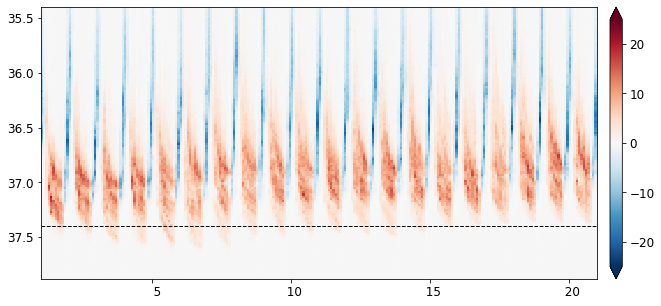

In [6]:
fig = hovmoeller(ddict['CM4_piControl'].onshlf.sel(time=slice(None,'0020'))*1e-6, fsize=[12, 5], cmap='RdBu_r', 
                 yincrease=False,hline=[37.4],vrange=[-25,25])

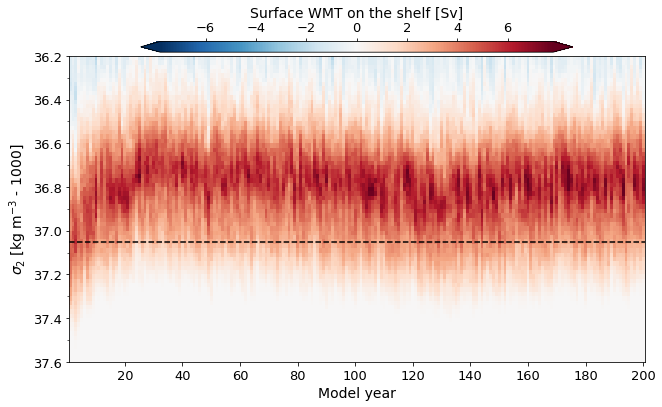

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9)
var = 'onshlf'
G = ddict['CM4_piControl_c192_OM4p125_v6_alt1'][var].groupby('time.year').mean('time')*1e-6
p = G.T.plot(ax=ax, yincrease=False, vmin=-7.8, vmax=7.8, cmap='RdBu_r' ,add_colorbar=False, add_labels=False)
ax.set_ylim([37.6,36.2])
ax.set_yticks(np.arange(37.6,36.2,-0.1), minor=True)
ax.set_xticks(np.arange(20,220,20), minor=False)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(y=37.05, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
#ax.set_title('Odiv-200', fontsize=14)
ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
ax.set_xlabel(r'Model year',fontsize=14)

cax = fig.add_axes([0.2, 0.91, 0.60, 0.03])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-6,8,2), orientation='horizontal', extend='both', shrink=0.7, pad=0.02)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=13)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

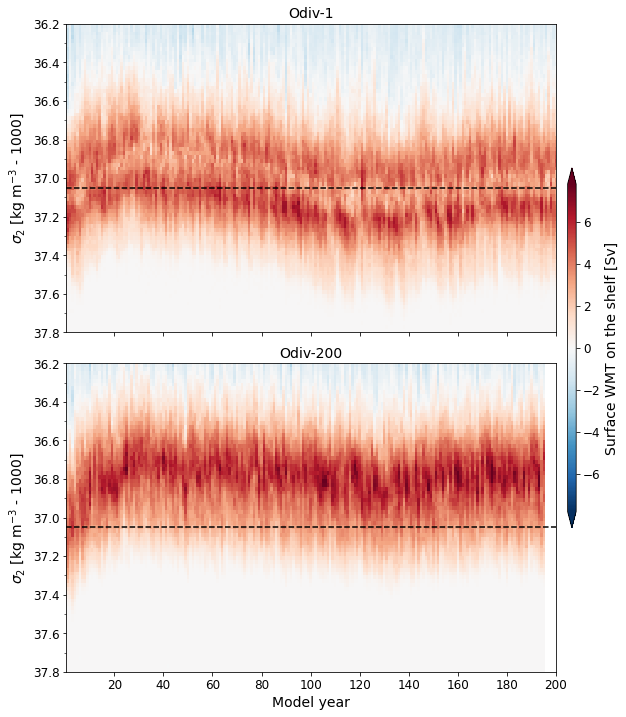

In [8]:
titlstr = ['Odiv-1','Odiv-200']
var = 'onshlf'
fig, axarr = plt.subplots(ncols=1, nrows=2, sharey=False, sharex=True, figsize=[8, 10])
fig.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.05, hspace=0.1)
for i, (ax, mod) in enumerate(zip(axarr.flat,['CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1'])):
    
    G = ddict[mod][var].groupby('time.year').mean('time')*1e-6
    p = G.T.plot(ax=ax, yincrease=False, vmin=-7.8, vmax=7.8, cmap='RdBu_r' ,add_colorbar=False, add_labels=False)
    ax.set_ylim([37.8,36.2])
    ax.set_yticks(np.arange(36.2,37.9,0.1), minor=True)
    ax.set_xlim([None,200])
    ax.set_xticks(np.arange(20,220,20), minor=False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axhline(y=37.05, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
    ax.set_title(titlstr[i], fontsize=14)
    ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
    if i==1:
        ax.set_xlabel(r'Model year',fontsize=14)

cax = fig.add_axes([0.92, 0.25, 0.015, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-6,8,2), orientation='vertical', extend='both', shrink=0.7, pad=0.02)
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

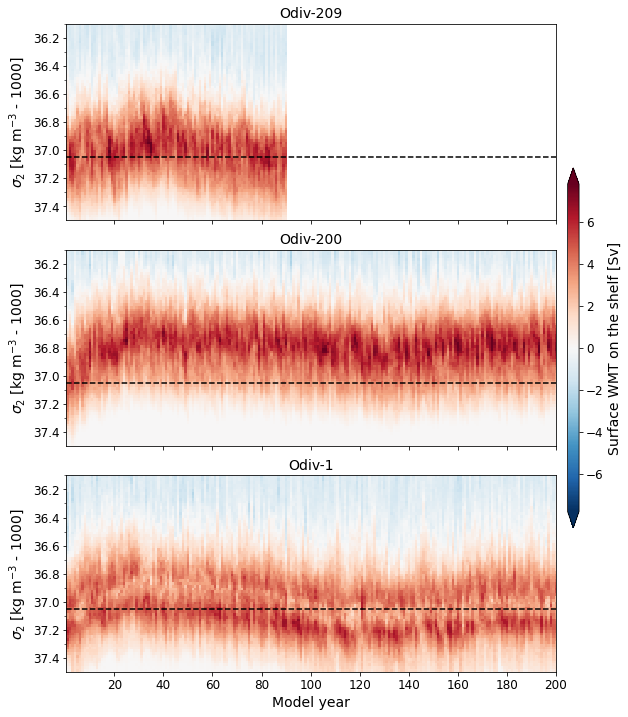

In [8]:
titlstr = ['Odiv-209','Odiv-200','Odiv-1']
var = 'onshlf'
fig, axarr = plt.subplots(ncols=1, nrows=3, sharey=False, sharex=True, figsize=[8, 10])
fig.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.05, hspace=0.15)
for i, (ax, mod) in enumerate(zip(axarr.flat,['CM4_piControl_c192_OM4p125_v7','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl'])):
    
    G = ddict[mod][var].groupby('time.year').mean('time')*1e-6
    p = G.T.plot(ax=ax, yincrease=False, vmin=-7.8, vmax=7.8, cmap='RdBu_r' ,add_colorbar=False, add_labels=False)
    ax.set_ylim([37.5,36.1])
    ax.set_yticks(np.arange(36.1,37.5,0.1), minor=True)
    ax.set_xlim([None,200])
    ax.set_xticks(np.arange(20,220,20), minor=False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axhline(y=37.05, xmin=0, xmax=1, linewidth=1.5, color = 'k',ls='--', alpha=1.0)
    ax.set_title(titlstr[i], fontsize=14)
    ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
    if i==2:
        ax.set_xlabel(r'Model year',fontsize=14)

cax = fig.add_axes([0.92, 0.25, 0.02, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-6,8,2), orientation='vertical', extend='both', shrink=0.7, pad=0.02)
cb.set_label('Surface WMT on the shelf [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

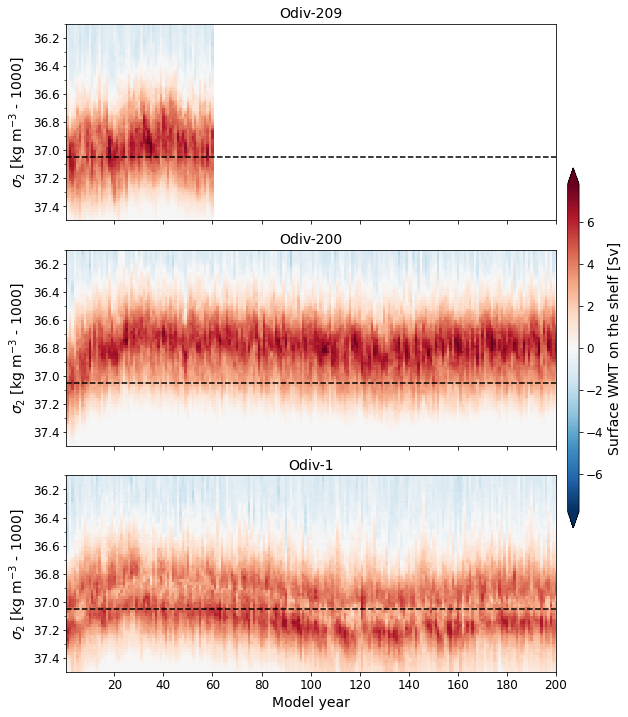

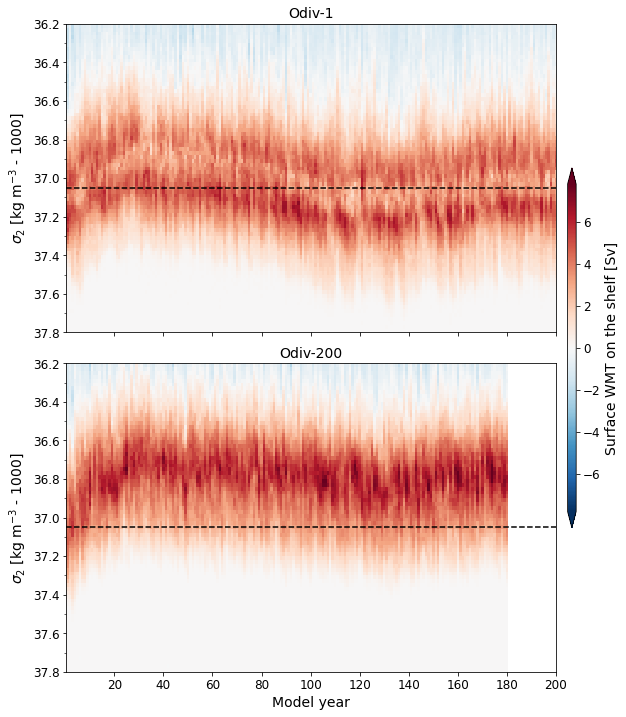

## Decompose

In [27]:
fname = 'CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc'
G = xr.open_dataset(outdir+fname).sel(time=slice('0051','0100'))

In [29]:
G

<xarray.Dataset>
Dimensions:       (time: 600, sigma2: 124)
Coordinates:
  * time          (time) object 0051-01-16 12:00:00 ... 0100-12-16 12:00:00
  * sigma2        (sigma2) float64 35.41 35.43 35.45 35.47 ... 37.83 37.85 37.87
Data variables:
    onshlf_heat   (time, sigma2) float64 -1.446e+06 -1.633e+06 ... 0.0 0.0
    onshlf_salt   (time, sigma2) float64 -5.471e+06 -5.773e+06 ... 0.0 0.0
    onshlf_total  (time, sigma2) float64 -6.917e+06 -7.406e+06 ... 0.0 0.0
    offshr_heat   (time, sigma2) float64 -1.958e+06 -2.126e+06 ... 0.0 0.0
    offshr_salt   (time, sigma2) float64 -3.102e+06 -3.531e+06 ... 0.0 0.0
    offshr_total  (time, sigma2) float64 -5.059e+06 -5.657e+06 ... 0.0 0.0

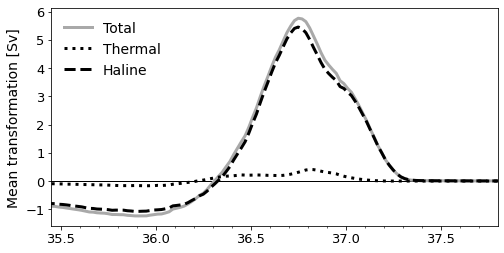

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G.mean('time').onshlf_total*1e-6, color='darkgrey', linestyle='-', lw=3, label='Total')#,marker='.')
ax.plot(G[lstr], G.mean('time').onshlf_heat*1e-6, color='k', linestyle=':', lw=3, label='Thermal')
ax.plot(G[lstr], G.mean('time').onshlf_salt*1e-6, color='k', linestyle='--', lw=3, label='Haline')

ax.legend(frameon=False, fancybox=False, loc='upper left',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlim([35.45,37.8])
ax.set_xticks(np.arange(35.5,37.8,0.1), minor=True)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [35]:
dsG = xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0110_southof600S_swmt_onvoffshelf_decomposed_haline_sigma2_002.nc')

In [36]:
reg = 'onshlf' # offshr, onshlf
G = xr.Dataset(data_vars={})    
for v in dsG.keys():
    if v[:6] == reg:
        G[v[7:]] = dsG[v]
        
G['total'] = xr.open_dataset(outdir+fname).onshlf_salt
G = G.drop_vars('total_mass').sel(time=slice('0051','0100'))

sum_of_components = xr.zeros_like(G.total)
components = [v for v in G.keys() if v != 'total']
for v in components:
    sum_of_components += G[v]

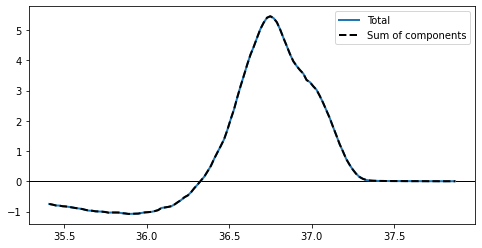

In [37]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G[lstr], G['total'].mean('time')*1e-6, lw=2, linestyle='-', label='Total')
ax.plot(G[lstr], sum_of_components.mean('time')*1e-6, color='k', lw=2, linestyle='--', label='Sum of components')
ax.legend()
plt.show()

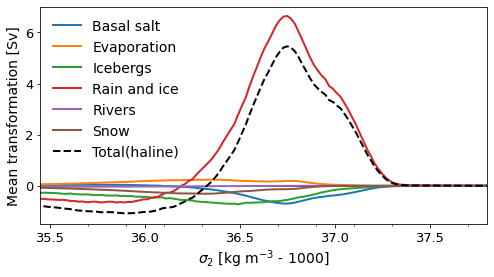

In [45]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
for v in G.keys():
    if v != 'total':
        ax.plot(G[lstr], G[v].mean('time')*1e-6, lw=2, linestyle='-', label=v.replace('_',' ').capitalize())
    else:
        ax.plot(G[lstr], G[v].mean('time')*1e-6, lw=2, linestyle='--', c = 'k', label=v.capitalize()+ '(haline)')

#ax.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
ax.legend(frameon=False, fancybox=False, loc='upper left',fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlim([35.45,37.8])
ax.set_xticks(np.arange(35.5,37.8,0.2), minor=True)
ax.set_ylim([-1.5,7])
ax.set_xlabel('$\sigma_2$ [kg m$^{-3}$ - 1000]', fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

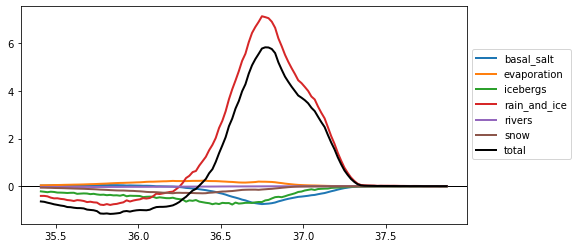

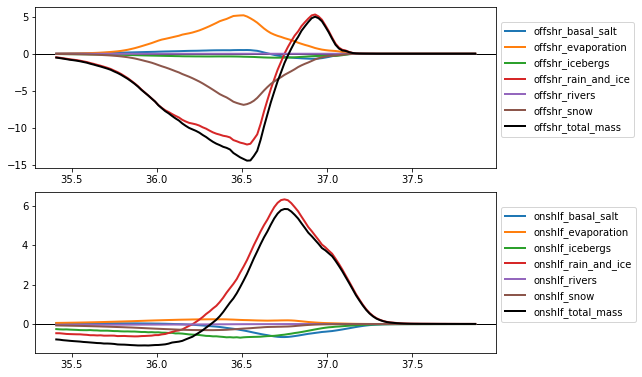